In [1]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import json
import inspect
import collections
from collections import OrderedDict
from datetime import datetime as dt
import time
import re
import ast

In [2]:
response = requests.get(url='https://store.steampowered.com/appreviews/413150?json=1').json()

In [3]:
#response

In [4]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()


In [5]:
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [6]:
#def get_app_id(game_name):
#    response = requests.get(url=f'https://store.steampowered.com/search/?term={game_name}&category1=998', headers={'User-Agent': 'Mozilla/5.0'})
#    soup = BeautifulSoup(response.text, 'html.parser')
#    app_id = soup.find(class_='search_result_row')['data-ds-appid']
#    
#    return app_id

In [7]:
#To get a bunch of app IDs at once
def get_n_appids(n=100, filter_by='topsellers'):
    appids = []
    url = f'https://store.steampowered.com/search/?category1=998&filter={filter_by}&page='
    page = 0

    while page*25 < n:
        page += 1
        response = requests.get(url=url+str(page), headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for row in soup.find_all(class_='search_result_row'):
            appids.append(row['data-ds-appid'])

    return appids[:n]

In [8]:
#see how long it takes to execute this cell
start = time.time()

reviews = []
appids = get_n_appids(100) #100 app/"game" IDs, 100 top sellers?
for appid in appids:
    reviews += get_n_reviews(appid, 100)


end = time.time()

total_time = end - start
print("\n" + str(total_time))


49.23716926574707


In [9]:
#want to see how reviews looks like.
reviews

#first of all can look up who wrote the review/go to the actual review on Steam by looking up 'steamid'
#might be good to only look at reviews with substantial playtime_forever & playtime_last_two_weeks -> need to parse from "author"
#also 'votes_up' to see how many people found it helpful & votes_funny
#weighted_vote_score - might be good to pull it in to see how it varies

[{'recommendationid': '132534295',
  'author': {'steamid': '76561198012052601',
   'num_games_owned': 2757,
   'num_reviews': 39,
   'playtime_forever': 5141,
   'playtime_last_two_weeks': 5141,
   'playtime_at_review': 2625,
   'last_played': 1676329379},
  'language': 'english',
  'review': '[h1]A dream for every Potterhead and those who want to become one![/h1]\n[b][u]Spoiler free Review![/u][/b]\n\n\nSometimes games are getting released with way too much hype. Forspoken, as an example, would be such a game. Either is it because of bad optimization or misinformation by the studio, the disappointment can end up being immeasurable for people who already pre-ordered these games, or people who have those games on their wishlist for months. Sadly, we had a lot of those lately. Don\'t even get me started with license games in general....\n\nHogwarts Legacy, on the other hand, shows that sometimes the hype train can be true.\n\nI don\'t usually pre-order games anymore, but the premise of b

In [10]:
df_init = pd.DataFrame(reviews)[['review','author','votes_up','votes_funny','weighted_vote_score', 'voted_up']]


In [11]:
df_init.shape

(9300, 6)

In [70]:
df_init.head()

review  \
0  [h1]A dream for every Potterhead and those who want to become one![/h1]\n[b][u]Spoiler free Review![/u][/b]\n\n\nSometimes games are getting released with way too much hype. Forspoken, as an example, would be such a game. Either is it because of bad optimization or misinformation by the studio, the disappointment can end up being immeasurable for people who already pre-ordered these games, or people who have those games on their wishlist for months. Sadly, we had a lot of those lately. Don't even get me started with license games in general....\n\nHogwarts Legacy, on the other hand, shows that sometimes the hype train can be true.\n\nI don't usually pre-order games anymore, but the premise of being the best game based on the fantastic world of "Harry Potter" made me buy it in an instant.\n\nThe following review won't contain any spoilers! I also want to mention that I am not even close to the end of the game, because I have way too much fun exploring.\n\n[i]Also I know about the controversy, but it won't be part of my review (Not even as a meme!).[/i]\nhttps://steamcommunity.com/sharedfiles/filedetails/?id=2929913613\n\n\n[h1]Story:[/h1]\nSo far so good. It starts off with a generic "You are the chosen one!" scenario, but it is going to get better and better the further you go. You just have to trust me on this one, because I don't want to give away too many information. All I can say is that the story fits the HP universe very well. If this game would be a book I wouldn't be able to stop reading it until the very end.\n\n\n[h1]Gameplay:[/h1]\nOverwhelming, would be the right word. There are so many mechanics in this game it is amazing and exhausting at the same time.\n\nFirst off you have the exploration part, where you can move around freely and explore every inch of Hogwarts and its surroundings. I tell you there is a lot to discover and to collect. Mysteries that need to be solved, locks that need to be picked and information about special places that need to be gathered. The amount of collectibles are insane and you will most likely spent hours over hours getting everything to 100%. The puzzles you can find are very well-made and solving them is fun.\n\nThen you have your main quests and side quests. I really love the side quests in this one, because they involve your fellow students. You learn to know them a bit better every time and the most of the quests are very creative.\n\nAlso: You don't get exp by fighting enemies! You get exp by discovering new locations, doing mini games or other things like that.\n\nIf you want to get from one point of the map to the other, you can also use the "Floo powder" fast travel service, or use your good old broom! I prefer the last one. It just feels great to fly around and enjoy the world. It might even sometimes happens that I just fly around aimlessly just for fun.  \n\nDecorating, Crafting and Fantastic Beasts are going to be part of the game as well. But it would be way too spoilery to mention anything more! \n\n\n[h1]The Combat:[/h1]\n\nWhat would be a wizard/witch without a magical wand. Most of the time you might be using it for puzzles, lighten up the area or scanning your surroundings, but the further you go the stronger enemies you have to face. Good that you start to learn attack and defense spells very soon. There might just be a handful of them, but the key is that you can combine them. Hit an enemy with 3 basic spells, pull it towards you, hit 3 more times, set it in flames, push it back and hit it ones again. Different combos cause different effects, combining them makes them stronger. You learn those combos as well, but you are also free to experiment on your own. \n\nFighting the enemies also never gets old. Some of them might have shields and you need the right spells to break through them and others can only be dealt with when they get attacked by fire. \n\nFor your defense you can also use a shield spell or dodge roll out of the danger zone. It should 

In [13]:
#Need to parse out the data from the author field
pd.set_option('display.max_colwidth', None)
print(df_init['author'].head(1)) #example of what this author column looks like.

0    {'steamid': '76561198012052601', 'num_games_owned': 2757, 'num_reviews': 39, 'playtime_forever': 5141, 'playtime_last_two_weeks': 5141, 'playtime_at_review': 2625, 'last_played': 1676329379}
Name: author, dtype: object


### Extracting more data from the author column

In [14]:
#Convert this column to list first
df_init['author'].head()

0    {'steamid': '76561198012052601', 'num_games_owned': 2757, 'num_reviews': 39, 'playtime_forever': 5141, 'playtime_last_two_weeks': 5141, 'playtime_at_review': 2625, 'last_played': 1676329379}
1     {'steamid': '76561198111425467', 'num_games_owned': 238, 'num_reviews': 34, 'playtime_forever': 5216, 'playtime_last_two_weeks': 5216, 'playtime_at_review': 2503, 'last_played': 1676345302}
2      {'steamid': '76561198006556385', 'num_games_owned': 132, 'num_reviews': 2, 'playtime_forever': 3630, 'playtime_last_two_weeks': 3630, 'playtime_at_review': 3475, 'last_played': 1676240907}
3        {'steamid': '76561198330419772', 'num_games_owned': 227, 'num_reviews': 82, 'playtime_forever': 102, 'playtime_last_two_weeks': 102, 'playtime_at_review': 102, 'last_played': 1676161448}
4       {'steamid': '76561198807676375', 'num_games_owned': 39, 'num_reviews': 1, 'playtime_forever': 2540, 'playtime_last_two_weeks': 2540, 'playtime_at_review': 2065, 'last_played': 1676333274}
Name: author, dtype:

In [15]:
author_fields = df_init['author'].values.tolist()

In [16]:
author_df = pd.DataFrame(author_fields, columns = ['steamid','num_games_owned','num_reviews','playtime_forever',
                                                   'playtime_last_two_weeks','playtime_at_review','last_played'])

In [17]:
author_df.shape

(9300, 7)

In [18]:
df = pd.concat([df_init, author_df], axis=1)

In [19]:
#df.head() #the author columns are included now

In [20]:
df.columns

Index(['review', 'author', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'voted_up', 'steamid', 'num_games_owned', 'num_reviews',
       'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review',
       'last_played'],
      dtype='object')

In [21]:
#subset and rearrange columns
#won't really need "last_played"
df = df[['steamid','review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [22]:
df.head()
#first review is weird.

steamid  \
0  76561198012052601   
1  76561198111425467   
2  76561198006556385   
3  76561198330419772   
4  76561198807676375   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [71]:
#Proportion of reviews with thumbs up or down
df['voted_up'].value_counts()

True     7566
False    1733
Name: voted_up, dtype: int64

In [24]:
#examples of reviews that received a thumbs down
df[df['voted_up']==False]

steamid  \
41    76561198017918223   
42    76561198011188250   
49    76561198060509134   
60    76561198318871359   
64    76561198121347683   
...                 ...   
9282  76561198023827795   
9287  76561198037747023   
9289  76561198112492897   
9290  76561198117009684   
9297  76561197997555853   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Import NLP modeling libraries

In [69]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models
import torch
from tqdm import tqdm
torch.cuda.is_available()

False

#### Next: lowercase, remove special characters/only keep letters, remove stop words, etc.

In [26]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

#Create a function that tries to clean the reviews
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower() #lowercase
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext) #remove weblinks
    rem_num = re.sub('[0-9]+', '', rem_url) #remove numbers
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')] #remove stop words
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)




In [27]:
#First row looks weird..try taking it out
df = df.iloc[1:]

In [72]:
df.head()

,clean_review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up,voted_up_target,review_length
1,finally something half baked live service micro transaction infested disaster launch,238,34,5216,5216,2503,5050,148,0.941862583160400391,True,1,84
2,finished first playthrough game put hours point completed content outside steam trophies personally really enjoyed game think great release everything ever wanted harry potter game story good voice acting actually phenomenal part non player characters player characters slight issue robotic voice likely due pitch nothing game breaking combat engaging though lament lack variety comes enemies confront hogwarts world represented incredible detail lost running castle taking gripes game sadly hope fixed line lack photo mode example animation issues certain foes like trolls rubberband follow player character complete animations said lack enemy variety well wish missions school focused around student life quickly feel like part time student castle lack bit classes take learn universe even student activities like quidditch wizards chess outside slight gripes game think avalanche terrific job bringing universe harry potter life game look forward future may via dlc potential similar games exploring parts wizarding world academies like ilvermorny beauxbâtons durmstrang even stories focused around adults universe ministries believe lot people may enjoy playing auror unspeakable,132,2,3630,3630,3475,759,14,0.939594626426696777,True,1,1183
3,everything real life like casting magic talking girls,227,82,102,102,102,4974,4974,0.938642978668212891,True,1,53
4,pet every single cat,39,1,2540,2540,2065,4854,574,0.935093224048614502,True,1,20
5,shadow wizard money gang love casting spells,63,9,1330,1330,966,1653,436,0.933933615684509277,True,1,44


#### Apply the preprocess function

In [29]:
start = time.time()

df['clean_review']=df['review'].map(lambda s:preprocess(s))

end = time.time()

total_time = end - start
print("\n" + str(total_time))


322.04912209510803


In [30]:
#keep a copy here just in case.
df_backup = df.copy()

In [31]:
#df.head()

In [32]:
#df['steamid'].nunique()

In [33]:
#Again, reorder and subset columns
df = df[['clean_review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [34]:
df.head()

,clean_review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up
1,finally something half baked live service micro transaction infested disaster launch,238,34,5216,5216,2503,5050,148,0.941862583160400391,True
2,finished first playthrough game put hours point completed content outside steam trophies personally really enjoyed game think great release everything ever wanted harry potter game story good voice acting actually phenomenal part non player characters player characters slight issue robotic voice likely due pitch nothing game breaking combat engaging though lament lack variety comes enemies confront hogwarts world represented incredible detail lost running castle taking gripes game sadly hope fixed line lack photo mode example animation issues certain foes like trolls rubberband follow player character complete animations said lack enemy variety well wish missions school focused around student life quickly feel like part time student castle lack bit classes take learn universe even student activities like quidditch wizards chess outside slight gripes game think avalanche terrific job bringing universe harry potter life game look forward future may via dlc potential similar games exploring parts wizarding world academies like ilvermorny beauxbâtons durmstrang even stories focused around adults universe ministries believe lot people may enjoy playing auror unspeakable,132,2,3630,3630,3475,759,14,0.939594626426696777,True
3,everything real life like casting magic talking girls,227,82,102,102,102,4974,4974,0.938642978668212891,True
4,pet every single cat,39,1,2540,2540,2065,4854,574,0.935093224048614502,True
5,shadow wizard money gang love casting spells,63,9,1330,1330,966,1653,436,0.933933615684509277,True


In [73]:
#No nulls
df.isna().sum()

clean_review               0
num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
votes_up                   0
votes_funny                0
weighted_vote_score        0
voted_up                   0
voted_up_target            0
review_length              0
dtype: int64

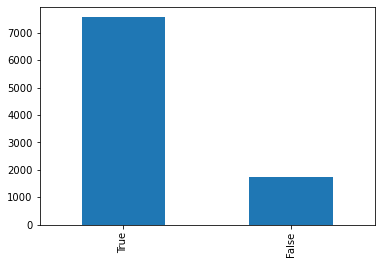

In [36]:
#Compare target class
df['voted_up'].value_counts().plot(kind='bar')

In [37]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [38]:
df_pos = df[df['voted_up']==True]
df_pos.shape

(7566, 10)

In [39]:
df_neg = df[df['voted_up']==False]
df_neg.shape

(1733, 10)

In [40]:
#Build wordcloud
wc = WordCloud(stopwords = stop_words, collocations = False, max_font_size=55, max_words=50, background_color='white')

## Word Cloud for Reviews Voted Up

(-0.5, 399.5, 199.5, -0.5)

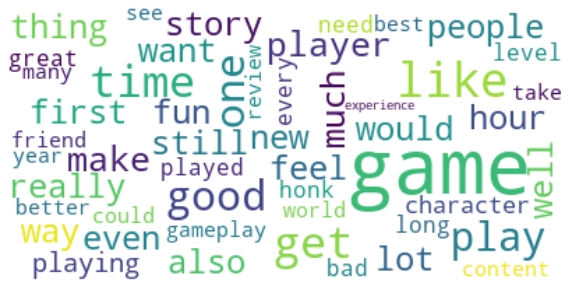

In [74]:
wc.generate(' '.join(df_pos['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Up Reviews WordCloud

## Word Cloud for Reviews Voted Down

(-0.5, 399.5, 199.5, -0.5)

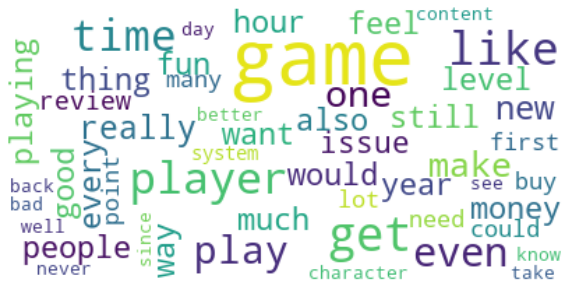

In [42]:
wc.generate(' '.join(df_neg['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Down Reviews Wordcloud

### Change Target Column to Binary -> just change bool to int()


In [43]:
df['voted_up_target'] = df['voted_up'].astype(int)

### Remove (Consecutively) Repeated Words

In [45]:
df.iloc[2] #Ex) "spoiler spoiler"

clean_review               everything real life like casting magic talking girls
num_games_owned                                                              227
num_reviews                                                                   82
playtime_forever                                                             102
playtime_last_two_weeks                                                      102
playtime_at_review                                                           102
votes_up                                                                    4974
votes_funny                                                                 4974
weighted_vote_score                                         0.938642978668212891
voted_up                                                                    True
voted_up_target                                                                1
Name: 3, dtype: object

In [46]:
#Use this to get rid of consecutive duplicates ONLY
df['clean_review'] = df['clean_review'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')

#Use this to removes non-consecutive duplicates
#df['clean_review'] = (df['clean_review'].str.split()
#                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
#                              .str.join(' '))


<ipython-input-46-97b2061ddf58>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_review'] = df['clean_review'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')


In [47]:
df.iloc[2]

clean_review               everything real life like casting magic talking girls
num_games_owned                                                              227
num_reviews                                                                   82
playtime_forever                                                             102
playtime_last_two_weeks                                                      102
playtime_at_review                                                           102
votes_up                                                                    4974
votes_funny                                                                 4974
weighted_vote_score                                         0.938642978668212891
voted_up                                                                    True
voted_up_target                                                                1
Name: 3, dtype: object

### Additional Feature Engineering

In [48]:
# Review Length
df['review_length'] = df['clean_review'].apply(len)

Text(0.5, 1.0, 'Distribution of Review Lengths')

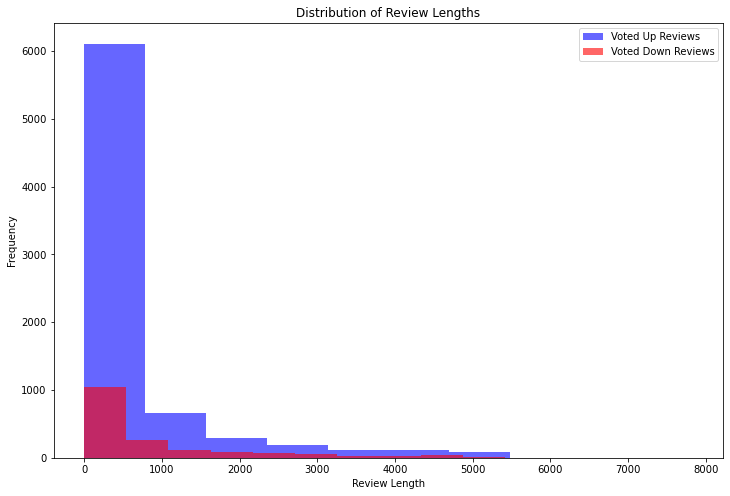

In [49]:
plt.figure(figsize=(12, 8))

df[df.voted_up_target == 1].review_length.plot(kind='hist', color='blue', 
                                       label='Voted Up Reviews', alpha=0.6)
df[df.voted_up_target == 0].review_length.plot(kind='hist', color='red', 
                                       label='Voted Down Reviews', alpha=0.6)
plt.legend()
plt.xlabel("Review Length")
plt.title('Distribution of Review Lengths')

In [50]:
#https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [ ]:
### Address the Unequal Text Length Problem(?)

#### Split data into training and test set

In [59]:
df.head()

,clean_review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up,voted_up_target,review_length
1,finally something half baked live service micro transaction infested disaster launch,238,34,5216,5216,2503,5050,148,0.941862583160400391,True,1,84
2,finished first playthrough game put hours point completed content outside steam trophies personally really enjoyed game think great release everything ever wanted harry potter game story good voice acting actually phenomenal part non player characters player characters slight issue robotic voice likely due pitch nothing game breaking combat engaging though lament lack variety comes enemies confront hogwarts world represented incredible detail lost running castle taking gripes game sadly hope fixed line lack photo mode example animation issues certain foes like trolls rubberband follow player character complete animations said lack enemy variety well wish missions school focused around student life quickly feel like part time student castle lack bit classes take learn universe even student activities like quidditch wizards chess outside slight gripes game think avalanche terrific job bringing universe harry potter life game look forward future may via dlc potential similar games exploring parts wizarding world academies like ilvermorny beauxbâtons durmstrang even stories focused around adults universe ministries believe lot people may enjoy playing auror unspeakable,132,2,3630,3630,3475,759,14,0.939594626426696777,True,1,1183
3,everything real life like casting magic talking girls,227,82,102,102,102,4974,4974,0.938642978668212891,True,1,53
4,pet every single cat,39,1,2540,2540,2065,4854,574,0.935093224048614502,True,1,20
5,shadow wizard money gang love casting spells,63,9,1330,1330,966,1653,436,0.933933615684509277,True,1,44


In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['voted_up_target'], test_size=0.2)

### Build Model with PyTorch

In [61]:
# build vocabulary, convert text => number
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=80)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=80)

Total distinct words: 29319


In [62]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [63]:
y_train.shape

(7439,)

In [64]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, total_word, embed_size, hidden_size, num_class, padding_index=0):
        super().__init__()
        self.total_word = total_word
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        
        self.embed = torch.nn.Embedding(num_embeddings=total_word, 
                                        embedding_dim=embed_size, 
                                        padding_idx=padding_index)
        self.lstm = torch.nn.LSTM(input_size=self.embed_size, 
                                  hidden_size=self.hidden_size, 
                                  num_layers=1,
                                  bidirectional=True,
                                  batch_first=True)
        self.classifier = torch.nn.Sequential(
            # TODO: add more Linear layer, Activation layer
            torch.nn.Linear(in_features=2*self.hidden_size, out_features=num_class)
        )
        
    def forward(self, X):
        out = self.embed(X)
        out, _ = self.lstm(out)
        out = self.classifier(out[:, -1, :])
        return out

NameError: name 'torch' is not defined